In [16]:
import math 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers
import tensorflow as tf
import seaborn as sns
import yfinance as yf # pacakage to load financial datasets from yahoo

sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction

today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = '2010-01-01'

Tensorflow Version: 2.9.1
Num GPUs: 0


In [17]:
#Setting tickers

AMD = yf.Ticker('AMD')
INTC = yf.Ticker('INTC')
NVDA = yf.Ticker('NVDA')

In [18]:
#Building ticker DF

df_AMD = yf.download('AMD', start = start_date, end = end_date)
df_INTC = yf.download('INTC', start = start_date, end = end_date)
df_NVDA = yf.download('NVDA', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
df_AMD

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,9.790000,9.900000,9.680000,9.700000,9.700000,18748700
2010-01-05,9.710000,9.900000,9.680000,9.710000,9.710000,22145700
2010-01-06,9.680000,9.760000,9.550000,9.570000,9.570000,18643400
2010-01-07,9.510000,9.550000,9.180000,9.470000,9.470000,26806800
2010-01-08,9.370000,9.470000,9.290000,9.430000,9.430000,13752800
...,...,...,...,...,...,...
2022-05-18,100.000000,104.220001,95.709999,96.279999,96.279999,142603200
2022-05-19,96.690002,100.690002,95.089996,96.669998,96.669998,141506200
2022-05-20,98.389999,98.639999,88.260002,93.500000,93.500000,163996500


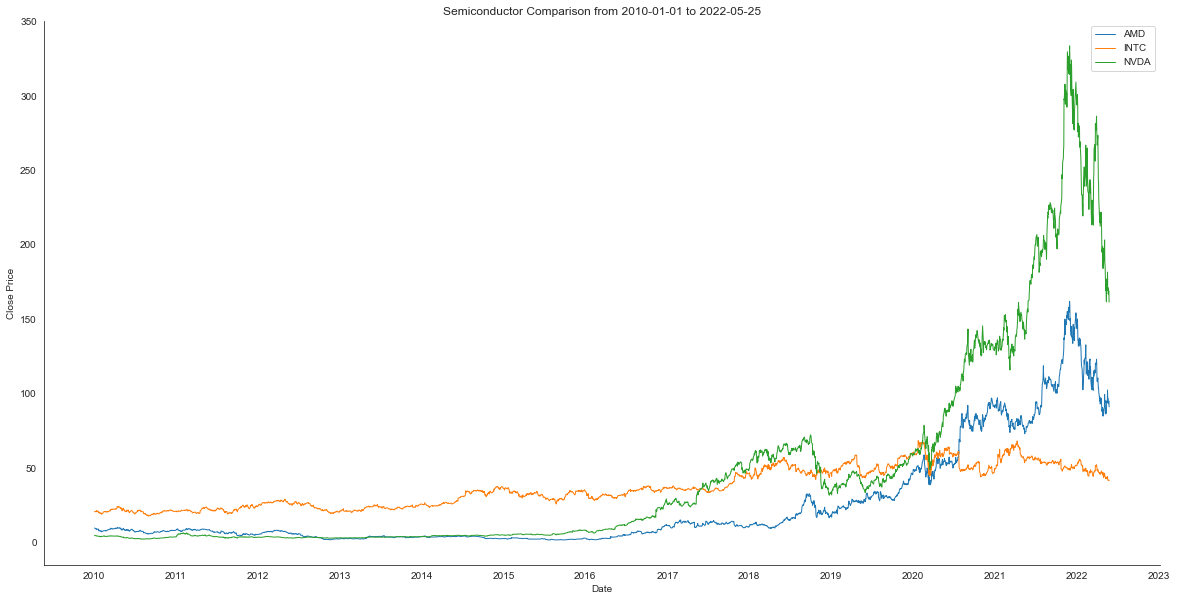

In [20]:
# Exploring the data

# Creating a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.xaxis.set_major_locator(years)
ax1.legend(['AMD'], fontsize=12)
plt.title('Semiconductor Comparison' + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df_AMD['Close'], label='AMD', linewidth=1.0)
sns.lineplot(data=df_INTC['Close'], label='INTC', linewidth=1.0)
sns.lineplot(data=df_NVDA['Close'], label='NVDA', linewidth=1.0)
plt.ylabel('Close Price')
plt.show()

In [21]:
# Feature Selection - Only Close Data
train_df = df_AMD.filter(['Close'])

In [22]:
#Scaling the Data

#AMD
# Feature Selection - Only Close Data
train_df_AMD = df_AMD.filter(['Close'])
data_unscaled_AMD = train_df_AMD.values

# Get the number of rows to train the model on 80% of the data 
train_data_length_AMD = math.ceil(len(data_unscaled_AMD) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler_AMD = MinMaxScaler(feature_range=(0, 1))
np_data_AMD = mmscaler_AMD.fit_transform(data_unscaled_AMD)

#INTC
# Feature Selection - Only Close Data
train_df_INTC = df_INTC.filter(['Close'])
data_unscaled_INTC = train_df_INTC.values

# Get the number of rows to train the model on 80% of the data 
train_data_length_INTC = math.ceil(len(data_unscaled_INTC) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler_INTC = MinMaxScaler(feature_range=(0, 1))
np_data_INTC = mmscaler_INTC.fit_transform(data_unscaled_INTC)

#NVDA
# Feature Selection - Only Close Data
train_df_NVDA = df_NVDA.filter(['Close'])
data_unscaled_NVDA = train_df_NVDA.values

# Get the number of rows to train the model on 80% of the data 
train_data_length_NVDA = math.ceil(len(data_unscaled_NVDA) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler_NVDA = MinMaxScaler(feature_range=(0, 1))
np_data_NVDA = mmscaler_NVDA.fit_transform(data_unscaled_NVDA)

In [23]:
#Creating Input Shape 

#AMD
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close_AMD = train_df_AMD.columns.get_loc("Close")
print(index_Close_AMD)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len_AMD = math.ceil(np_data_AMD.shape[0] * 0.8)

# Create the training and test data
train_data_AMD = np_data_AMD[0:train_data_len_AMD, :]
test_data_AMD = np_data_AMD[train_data_len_AMD - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df_AMD):
    x, y = [], []
    data_len_AMD = train_df_AMD.shape[0]
    for i in range(sequence_length, data_len_AMD):
        x.append(train_df_AMD[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df_AMD[i, index_Close_AMD]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train_AMD, y_train_AMD = partition_dataset(sequence_length, train_data_AMD)
x_test_AMD, y_test_AMD = partition_dataset(sequence_length, test_data_AMD)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train_AMD.shape, y_train_AMD.shape)
print(x_test_AMD.shape, y_test_AMD.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test_AMD[1][sequence_length-1][index_Close_AMD])
print(y_test_AMD[0])

0
(2446, 50, 1) (2446,)
(624, 50, 1) (624,)
0.2325784557395459
0.2325784557395459


In [24]:
#INTC
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close_INTC = train_df_INTC.columns.get_loc("Close")
print(index_Close_INTC)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len_INTC = math.ceil(np_data_INTC.shape[0] * 0.8)

# Create the training and test data
train_data_INTC = np_data_INTC[0:train_data_len_INTC, :]
test_data_INTC = np_data_INTC[train_data_len_INTC - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df_INTC):
    x, y = [], []
    data_len_INTC = train_df_INTC.shape[0]
    for i in range(sequence_length, data_len_INTC):
        x.append(train_df_INTC[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df_INTC[i, index_Close_INTC]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train_INTC, y_train_INTC = partition_dataset(sequence_length, train_data_INTC)
x_test_INTC, y_test_INTC = partition_dataset(sequence_length, test_data_INTC)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train_INTC.shape, y_train_INTC.shape)
print(x_test_INTC.shape, y_test_INTC.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test_INTC[1][sequence_length-1][index_Close_INTC])
print(y_test_INTC[0])

0
(2446, 50, 1) (2446,)
(624, 50, 1) (624,)
0.7559054872729349
0.7559054872729349


In [25]:
#NVDA
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close_NVDA = train_df_NVDA.columns.get_loc("Close")
print(index_Close_NVDA)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len_NVDA = math.ceil(np_data_NVDA.shape[0] * 0.8)

# Create the training and test data
train_data_NVDA = np_data_NVDA[0:train_data_len_NVDA, :]
test_data_NVDA = np_data_NVDA[train_data_len_NVDA - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df_NVDA):
    x, y = [], []
    data_len_NVDA = train_df_NVDA.shape[0]
    for i in range(sequence_length, data_len_NVDA):
        x.append(train_df_NVDA[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df_NVDA[i, index_Close_NVDA]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train_NVDA, y_train_NVDA = partition_dataset(sequence_length, train_data_NVDA)
x_test_NVDA, y_test_NVDA = partition_dataset(sequence_length, test_data_NVDA)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train_NVDA.shape, y_train_NVDA.shape)
print(x_test_NVDA.shape, y_test_NVDA.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test_NVDA[1][sequence_length-1][index_Close_NVDA])
print(y_test_NVDA[0])

0
(2446, 50, 1) (2446,)
(624, 50, 1) (624,)
0.1498914140900712
0.1498914140900712


In [26]:
#Define Model Architecture

#AMD
# Configure the neural network model
model_AMD = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model_AMD.add(LSTM(neurons, return_sequences=True, input_shape=(x_train_AMD.shape[1], 1))) 
model_AMD.add(LSTM(neurons, return_sequences=False))
model_AMD.add(Dense(25, activation='relu'))
model_AMD.add(Dense(1))

# Compile the model
model_AMD.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
#INTC
# Configure the neural network model
model_INTC = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model_INTC.add(LSTM(neurons, return_sequences=True, input_shape=(x_train_INTC.shape[1], 1))) 
model_INTC.add(LSTM(neurons, return_sequences=False))
model_INTC.add(Dense(25, activation='relu'))
model_INTC.add(Dense(1))

# Compile the model
model_INTC.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
#NVDA
# Configure the neural network model
model_NVDA = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model_NVDA.add(LSTM(neurons, return_sequences=True, input_shape=(x_train_NVDA.shape[1], 1))) 
model_NVDA.add(LSTM(neurons, return_sequences=False))
model_NVDA.add(Dense(25, activation='relu'))
model_NVDA.add(Dense(1))

# Compile the model
model_NVDA.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
#Train the Univariate Model

#AMD
# Training the model
model_AMD.fit(x_train_AMD, y_train_AMD, batch_size=16, epochs=25)

Epoch 1/25
153/153 [==============================] - 8s 28ms/step - loss: 1.9343e-04
Epoch 2/25
153/153 [==============================] - 4s 28ms/step - loss: 5.7764e-05
Epoch 3/25
153/153 [==============================] - 4s 27ms/step - loss: 4.6080e-05
Epoch 4/25
153/153 [==============================] - 4s 27ms/step - loss: 3.5216e-05
Epoch 5/25
153/153 [==============================] - 4s 27ms/step - loss: 3.3625e-05
Epoch 6/25
153/153 [==============================] - 4s 27ms/step - loss: 3.6448e-05
Epoch 7/25
153/153 [==============================] - 4s 27ms/step - loss: 3.0242e-05
Epoch 8/25
153/153 [==============================] - 4s 28ms/step - loss: 3.0478e-05
Epoch 9/25
153/153 [==============================] - 4s 28ms/step - loss: 3.1863e-05
Epoch 10/25
153/153 [==============================] - 4s 28ms/step - loss: 2.3286e-05
Epoch 11/25
153/153 [==============================] - 4s 27ms/step - loss: 3.1441e-05
Epoch 12/25
153/153 [==============================]

In [30]:
#INTC
# Training the model
model_INTC.fit(x_train_INTC, y_train_INTC, batch_size=16, epochs=25)

Epoch 1/25
153/153 [==============================] - 8s 28ms/step - loss: 0.0057
Epoch 2/25
153/153 [==============================] - 4s 28ms/step - loss: 7.1083e-04
Epoch 3/25
153/153 [==============================] - 4s 28ms/step - loss: 6.9252e-04
Epoch 4/25
153/153 [==============================] - 4s 28ms/step - loss: 5.3204e-04
Epoch 5/25
153/153 [==============================] - 4s 28ms/step - loss: 4.6646e-04
Epoch 6/25
153/153 [==============================] - 4s 28ms/step - loss: 4.3341e-04
Epoch 7/25
153/153 [==============================] - 4s 28ms/step - loss: 3.7214e-04
Epoch 8/25
153/153 [==============================] - 4s 28ms/step - loss: 3.0181e-04
Epoch 9/25
153/153 [==============================] - 4s 28ms/step - loss: 2.9259e-04
Epoch 10/25
153/153 [==============================] - 4s 28ms/step - loss: 2.6809e-04
Epoch 11/25
153/153 [==============================] - 4s 28ms/step - loss: 2.5072e-04
Epoch 12/25
153/153 [==============================] - 4

In [31]:
#NVDA
# Training the model
model_NVDA.fit(x_train_NVDA, y_train_NVDA, batch_size=16, epochs=25)

Epoch 1/25
153/153 [==============================] - 8s 27ms/step - loss: 3.0414e-04
Epoch 2/25
153/153 [==============================] - 4s 27ms/step - loss: 3.4711e-05
Epoch 3/25
153/153 [==============================] - 4s 28ms/step - loss: 3.0750e-05
Epoch 4/25
153/153 [==============================] - 4s 28ms/step - loss: 3.2538e-05
Epoch 5/25
153/153 [==============================] - 4s 28ms/step - loss: 2.5987e-05
Epoch 6/25
153/153 [==============================] - 4s 28ms/step - loss: 2.4819e-05
Epoch 7/25
153/153 [==============================] - 4s 28ms/step - loss: 2.1379e-05
Epoch 8/25
153/153 [==============================] - 4s 28ms/step - loss: 2.1012e-05
Epoch 9/25
153/153 [==============================] - 4s 28ms/step - loss: 2.4753e-05
Epoch 10/25
153/153 [==============================] - 4s 28ms/step - loss: 2.3796e-05
Epoch 11/25
153/153 [==============================] - 4s 28ms/step - loss: 2.1159e-05
Epoch 12/25
153/153 [==============================]

In [32]:
#Make Predictions

#AMD
# Get the predicted values
y_pred_scaled_AMD = model_AMD.predict(x_test_AMD)
y_pred_AMD = mmscaler_AMD.inverse_transform(y_pred_scaled_AMD)
y_test_unscaled_AMD = mmscaler_AMD.inverse_transform(y_test_AMD.reshape(-1, 1))

20/20 [==============================] - 1s 12ms/step


In [33]:
#INTC
# Get the predicted values
y_pred_scaled_INTC = model_INTC.predict(x_test_INTC)
y_pred_INTC = mmscaler_INTC.inverse_transform(y_pred_scaled_INTC)
y_test_unscaled_INTC = mmscaler_INTC.inverse_transform(y_test_INTC.reshape(-1, 1))

20/20 [==============================] - 1s 12ms/step


In [34]:
#NVDA
# Get the predicted values
y_pred_scaled_NVDA = model_NVDA.predict(x_test_NVDA)
y_pred_NVDA = mmscaler_NVDA.inverse_transform(y_pred_scaled_NVDA)
y_test_unscaled_NVDA = mmscaler_NVDA.inverse_transform(y_test_NVDA.reshape(-1, 1))

20/20 [==============================] - 1s 12ms/step


In [35]:
#Evaluate Model Performance

#AMD
# Mean Absolute Error (MAE) 
MAE = mean_absolute_error(y_test_unscaled_AMD, y_pred_AMD)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled_AMD, y_pred_AMD)/ y_test_unscaled_AMD))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled_AMD, y_pred_AMD)/ y_test_unscaled_AMD)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 5.83
Mean Absolute Percentage Error (MAPE): 6.14 %
Median Absolute Percentage Error (MDAPE): 5.89 %


In [36]:
train_AMD = pd.DataFrame(train_df_AMD[:train_data_length_AMD + 1]).rename(columns={'Close': 'x_train'})
train_AMD

,x_train
Date,
2010-01-04,9.700000
2010-01-05,9.710000
2010-01-06,9.570000
2010-01-07,9.470000
2010-01-08,9.430000
...,...
2019-11-26,38.990002
2019-11-27,39.410000
2019-11-29,39.150002


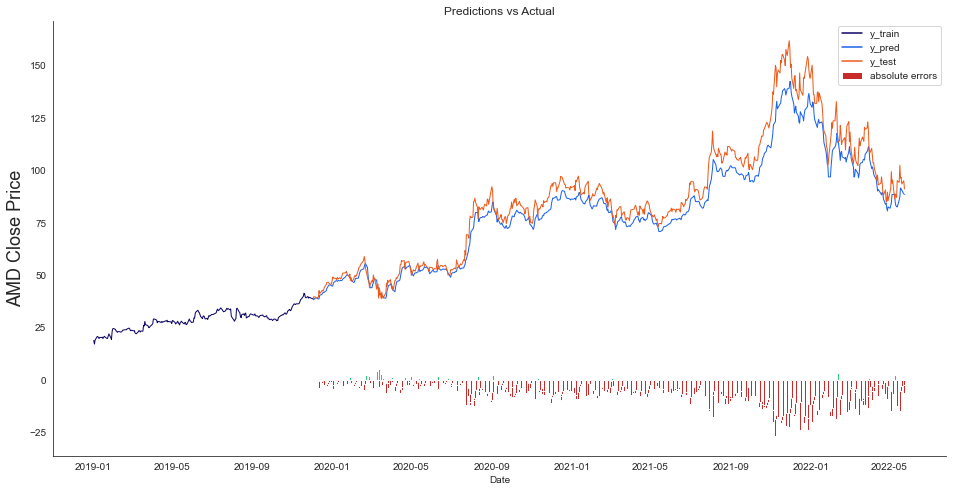

In [37]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_AMD[:train_data_length_AMD + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df_AMD[train_data_length_AMD:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred_AMD, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel('AMD Close Price', fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the barplot for the absolute errors
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [38]:
#Next Day's Price


# Get fresh data
df_new_AMD = df_AMD.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled_AMD = mmscaler_AMD.transform(df_new_AMD[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled_AMD)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model_AMD.predict(X_test)
pred_price_unscaled = mmscaler_AMD.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new_AMD['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

prefix = '+' if percent > 0 else ''
print(f'The close price for AMD at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({prefix}{percent}%)')

1/1 [==============================] - 0s 25ms/step
The close price for AMD at 2022-05-25 was 91.16
The predicted close price is 87.0199966430664 (+4.54%)


In [39]:
#INTC
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled_INTC, y_pred_INTC)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled_INTC, y_pred_INTC)/ y_test_unscaled_INTC))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled_INTC, y_pred_INTC)/ y_test_unscaled_INTC)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 0.94
Mean Absolute Percentage Error (MAPE): 1.74 %
Median Absolute Percentage Error (MDAPE): 1.22 %


In [40]:
train_INTC = pd.DataFrame(train_df_INTC[:train_data_length_INTC + 1]).rename(columns={'Close': 'x_train'})
train_INTC

,x_train
Date,
2010-01-04,20.879999
2010-01-05,20.870001
2010-01-06,20.799999
2010-01-07,20.600000
2010-01-08,20.830000
...,...
2019-11-26,58.900002
2019-11-27,58.509998
2019-11-29,58.049999


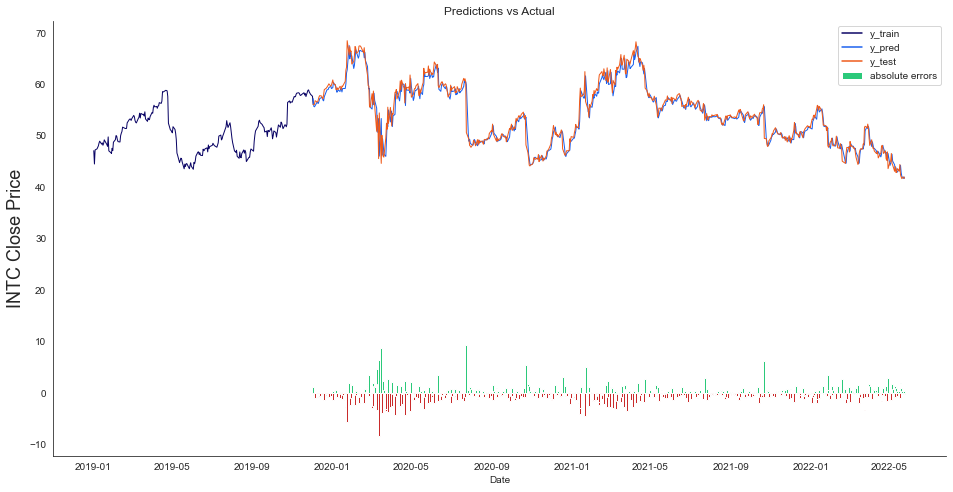

In [41]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_INTC[:train_data_length_INTC + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df_INTC[train_data_length_INTC:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred_INTC, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel('INTC Close Price', fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the barplot for the absolute errors
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [42]:
# Get fresh data
df_new_INTC = df_INTC.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled_INTC = mmscaler_INTC.transform(df_new_INTC[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled_INTC)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model_INTC.predict(X_test)
pred_price_unscaled = mmscaler_INTC.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new_INTC['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

prefix = '+' if percent > 0 else ''
print(f'The close price for INTC at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({prefix}{percent}%)')

1/1 [==============================] - 0s 24ms/step
The close price for INTC at 2022-05-25 was 41.67
The predicted close price is 41.83000183105469 (-0.38%)


In [43]:
#NVDA
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled_NVDA, y_pred_NVDA)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled_NVDA, y_pred_NVDA)/ y_test_unscaled_NVDA))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled_NVDA, y_pred_NVDA)/ y_test_unscaled_NVDA)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 14.69
Mean Absolute Percentage Error (MAPE): 7.46 %
Median Absolute Percentage Error (MDAPE): 6.72 %


In [44]:
train_NVDA = pd.DataFrame(train_df_NVDA[:train_data_length_NVDA + 1]).rename(columns={'Close': 'x_train'})
train_NVDA

,x_train
Date,
2010-01-04,4.622500
2010-01-05,4.690000
2010-01-06,4.720000
2010-01-07,4.627500
2010-01-08,4.637500
...,...
2019-11-26,54.250000
2019-11-27,54.560001
2019-11-29,54.185001


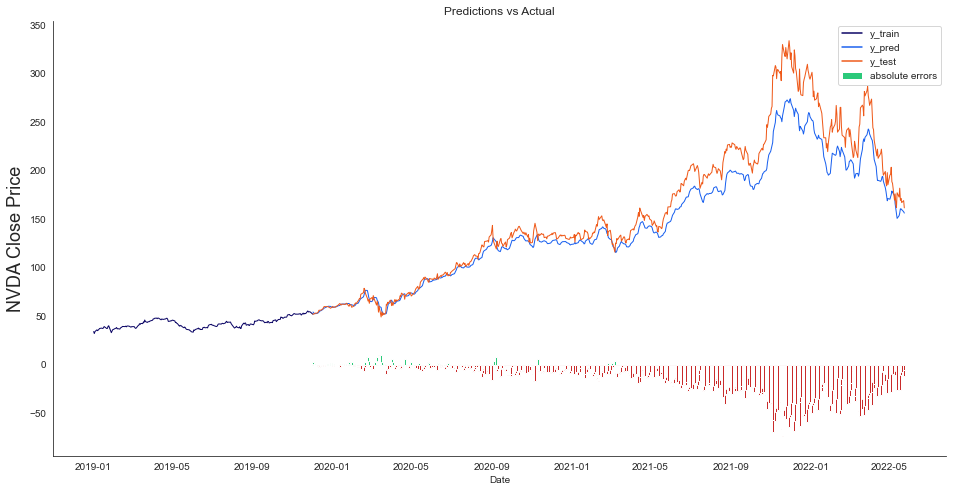

In [45]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_NVDA[:train_data_length_NVDA + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df_NVDA[train_data_length_NVDA:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred_NVDA, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel('NVDA Close Price', fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the barplot for the absolute errors
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [46]:
# Get fresh data
df_new_NVDA = df_NVDA.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled_NVDA = mmscaler_NVDA.transform(df_new_NVDA[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled_NVDA)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model_NVDA.predict(X_test)
pred_price_unscaled = mmscaler_NVDA.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new_NVDA['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

prefix = '+' if percent > 0 else ''
print(f'The close price for NVDA at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({prefix}{percent}%)')

1/1 [==============================] - 0s 24ms/step
The close price for NVDA at 2022-05-25 was 161.54
The predicted close price is 153.14999389648438 (+5.19%)
